In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install --upgrade albumentations

In [3]:
%cd /content/drive/MyDrive/EVA7/S7

/content/drive/MyDrive/EVA7/S7


## Importing the python Modules

In [4]:
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

from model import model
from utils.test import test
from utils.train import train
from utils.plot_images import *
from utils.fitmodel import fit_model


from utils.AlbumentationImageDataset import AlbumentationImageDataset

import matplotlib.pyplot as plt
import numpy as np




## Loading the dataset

In [5]:
# loading the dataset
cifar_10_database = datasets.CIFAR10('./data', train=True, download=True)
cifar_10_data = cifar_10_database.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Shape:', cifar_10_data.shape)
print(' - mean:', np.mean(cifar_10_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(cifar_10_data, axis=(0,1,2)) / 255.)

train_mean  = list(np.mean(cifar_10_data, axis=(0,1,2)) / 255.)
train_std = list(np.std(cifar_10_data, axis=(0,1,2)) / 255.)


Files already downloaded and verified
[Train]
 - Shape: (50000, 32, 32, 3)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]


## Plotting few images in dataset


In [6]:
def plot_data(data = None,cols=8, rows=4):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = data[i]

    figure.add_subplot(rows, cols, i)
    plt.title(data.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

In [7]:
# plot_data(cifar_10_database)

## Run in CUDA


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=256
else:
    BATCH_SIZE=256

CUDA Available: True


## Data Agumentation using albumentations

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


## Running Model


In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = model.Net(dropout=0.025).to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

## Training

In [12]:
training_output_data = fit_model(net,hardware=device, epochs=2,train_loader=train_loader, test_loader=test_loader)

epoch: 1


Batch_id=195 Loss=2.07534 Accuracy=20.47: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]



Test set: Average loss: 1.7407, Accuracy: 3443/10000 (34.43%)

epoch: 2


Batch_id=195 Loss=1.65695 Accuracy=38.39: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]



Test set: Average loss: 1.3381, Accuracy: 5054/10000 (50.54%)



{'train_Acc': [20.468, 38.388], 'train_Loss': [2.075335297657519, 1.6569524687163684], 'test_Acc': [34.43, 50.54], 'test_Loss': [1.7406849533081055, 1.338054371070862]}


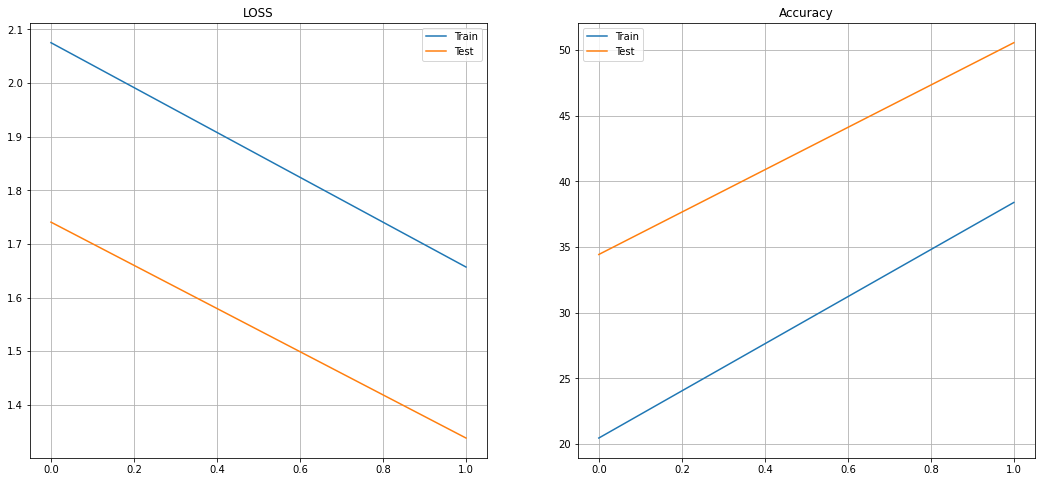

In [13]:
print(training_output_data)
train_accuracy = training_output_data["train_Acc"]
train_loss = training_output_data["train_Loss"]

test_accuracy = training_output_data["test_Acc"]
test_loss = training_output_data["test_Loss"]

plot_axis(train_loss=train_loss, test_loss=test_loss, train_accur = train_accuracy, test_accur=test_accuracy)